<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import urllib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


In [0]:
link = 'https://cdn.shopify.com/s/files/1/0014/3186/3369/products/U-PNDW-3-2.jpg?v=1534449006'

def urlToImage(url):
  resp = urllib.request.urlopen(url)
  img = np.asarray(bytearray(resp.read()), dtype='uint8')
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # img = np.expand_dims(img2show, axis=0)
  return img

img = urlToImage(link)


In [0]:
img

In [0]:
# Downloading the Image from the Internet
img = urlToImage(link)

# Resizing the image
height, width = 20, 20
original = cv2.resize(img, (width, height))

# Convering to grascale
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Making input output variables
inImg = outImg = cv2.resize(gray, (width, height))

Total Pixels : 400


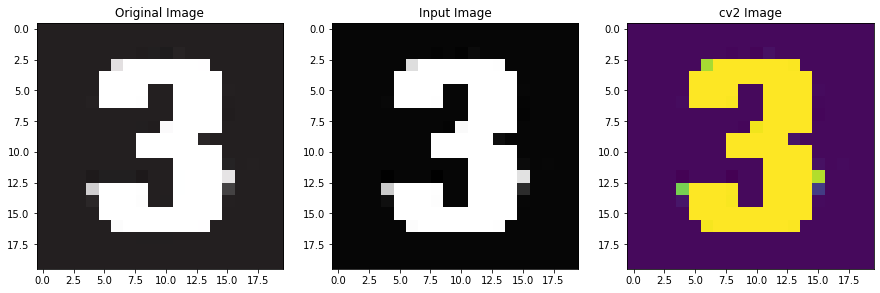

In [23]:
# PLOTTING

plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(inImg, cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 3)
plt.imshow(inImg)
plt.title('cv2 Image')

print('Total Pixels :', np.prod(inImg.shape))

In [27]:
# Creating training dataset
trainSet = []
SAMPLES  = 1

for i in range(SAMPLES):
  trainSet.append([torch.Tensor(inImg), torch.Tensor(outImg)])

print('Total number of training samples :', len(trainSet))

Total number of training samples : 1


In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2)

    self.flatten = None
    # # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(20, 20).view(-1, 1, 20, 20)
    x = self.convs(x)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, 1024)
    self.fc2   = nn.Linear(1024, 400)

  def convs(self, x):

    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))
    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self.flatten)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

In [0]:
def train(net, EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):

  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
  loss_func = nn.MSELoss()
  loss_log  = []

  for epoch in range(EPOCHS):
    print('Epoch :', epoch+1)
    for i in tqdm(range(0, len(trainSet), BATCH_SIZE)):
      x_batch = trainSet[i][0].view(-1, 1, 20, 20).to(device)/255.0
      y_batch = trainSet[i][1].view(-1, 1, 400).to(device)/255.0

      net.zero_grad()
      output = net(x_batch)
      loss = F.smooth_l1_loss(output, y_batch.float())
      loss.backward()
      optimizer.step()
      loss_log.append(loss)
      # break
    # print(f"Epoch : {epoch} || Loss : {loss}")

  return loss_log, output

net = Net().to(device)
loss_log, output = train(net, EPOCHS=50, BATCH_SIZE=1)

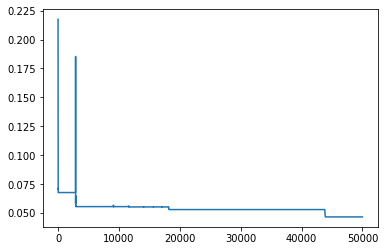

In [25]:
plt.plot(loss_log)

In [26]:
loss_log[-1]

tensor(0.0465, device='cuda:0', grad_fn=<SmoothL1LossBackward>)

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # self.fc1 = nn.Linear(400, 400)

        # self.fc2 = nn.Linear(4800, 4800)        
        # self.fc3 = nn.Linear(4800, 4800)        
        # self.fc4 = nn.Linear(4800, 4800)  

        self.fc1 = nn.Linear(400, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        # self.fc4 = nn.Linear(64, 32)
        # self.fc5 = nn.Linear(32, 64)        
        
        self.fc6 = nn.Linear(64, 128)        
        self.fc7 = nn.Linear(128, 256)        
        self.fc8 = nn.Linear(256, 400)        
    
    def forward(self, x):
        # for i in range(5):
        #   x = F.sigmoid(self.fc1(x))

        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        # x = F.sigmoid(self.fc4(x))
        # x = F.sigmoid(self.fc5(x))
        x = F.sigmoid(self.fc6(x))
        x = F.sigmoid(self.fc7(x))
        x = F.sigmoid(self.fc8(x))
        
        
        return x

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 200/200 [00:00<00:00, 302.24it/s]


Final Loss : tensor(4.5977e-05, grad_fn=<MseLossBackward>)


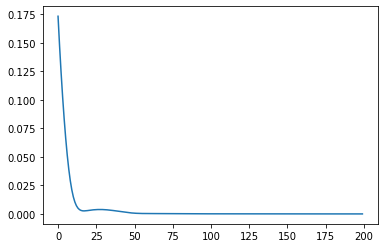

In [127]:
CONTINUE_TRAINING = False

LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 200
HEIGHT, WIDTH = height//8, width//8
TOTAL_PIXELS  = HEIGHT * WIDTH

if not CONTINUE_TRAINING:
  net = Net()
  loss_log = []
  outputs  = []

# loss_function = nn.SmoothL1Loss()
# Define Optimizer
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


# Iteration Begins
for epoch in tqdm(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in trainSet:
        x, y = data
        x = x/255.0
        y = y/255.0

        net.zero_grad()

        #Compute the output
        output = net(x.view(-1, TOTAL_PIXELS))
        
        # Saving every output image
        img = output.view(HEIGHT, WIDTH)
        img = img.detach().numpy()
        outputs.append(img)

        # Compute Loss
        loss = F.mse_loss(output, y.view(-1, TOTAL_PIXELS))
        loss_log.append(loss)

        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
    # print(loss)

plt.plot(loss_log)
print('Final Loss :', loss_log[-1])

In [0]:
7.7047e-05

In [128]:
# The network has been trained now. Time to predict with grad updates!
with torch.no_grad():
    for data in trainSet:
        x, y = data
        testOutput = net(x.view(-1, TOTAL_PIXELS))

testOutput = output.view(20, 20)
testOutput = testOutput.detach().numpy()*255

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


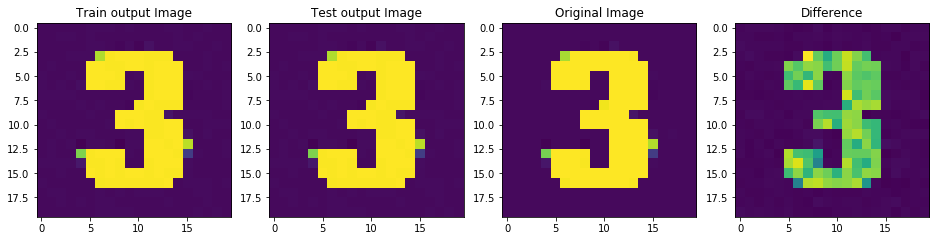

In [129]:
# Converting the tensor into numpy array and reshaping from VECTOR to 2D MATRIX
outputImage = output.view(HEIGHT, WIDTH)
outputImage = outputImage.detach().numpy()*255

plt.figure(figsize=(16, 16))

plt.subplot(1, 4, 1)
plt.title('Train output Image')
plt.imshow(outputImage)

plt.subplot(1, 4, 2)
plt.title('Test output Image')
plt.imshow(testOutput)

plt.subplot(1, 4, 3)
plt.title('Original Image')
plt.imshow(inImg)

differenceImage = np.abs(inImg-testOutput)
plt.subplot(1, 4, 4)
plt.title('Difference')
plt.imshow(differenceImage)

In [0]:
# np.save('/content/drive/My Drive/Colab Notebooks/encryption/output_images.npy', outputs)
# np.save('/content/drive/My Drive/Colab Notebooks/encryption/loss_log.npy', loss_log[:130])

In [0]:
model_state = {
    'epoch': 200,
    'loss_type' : 'mse_loss',
    'loss_log' : loss_log,
    'output_images' : outputs,
    'state_dict': net.state_dict(),
    'optimizer': optimizer.state_dict(),
}

In [0]:
torch.save(model_state, f'/content/drive/My Drive/Colab Notebooks/encryption/model_state_{int(time.time())}_{loss_log[-1]}')

In [0]:
'''
LOGS:

      Loss      |      Remarks
-------------------------------------------------
mse_loss       --> ? (worse than smooth_L1_loss)
smooth_l1_loss --> 0.0682 [learning_rate = 0.001]
kl_div         --> super bad
binary_cross_entropy_with_logits --> 0.6199
hinge_embedding_loss --> 1.0
l1_loss --> 0.2348

BEST SO FAR = smooth_l1_loss > l1_loss
'''